# Entropic learning for small data problems

Entropic learning methodologies include in their formulation a joint optimization of the discretization problem, dimensionality reduction and classification.
They are therefore able to detect and leverage the fact that only some of the dimensions should be taken into account.

In this notebook, we will use the same dataset used in the previous notebook and the same splits.

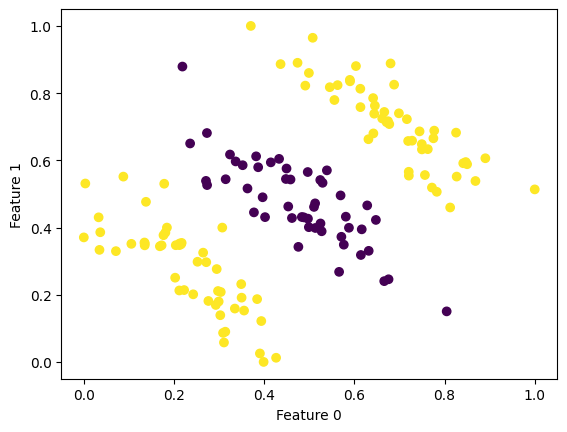

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from entlearn.models.EON import EON
from entlearn.models.eSPA import eSPA
from entlearn.utils.synthetic_data import make_worm
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,ShuffleSplit

np.random.seed(42)

T = 150
D = 500

X, y = make_worm(D=2, T=T, sigma=5)
X_small = np.column_stack((X, np.random.rand(T, D - 2)))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

In [2]:
inner_cv = ShuffleSplit(n_splits=1, random_state=42)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

## Entropic learning

Now, we will use entropic learning, on the same dataset used in the previous example.

In [3]:
names = [
    "eSPA+",
    "EON",
]

classifiers = [{
        "estimator": eSPA(anneals=10),
        "param_grid": {
            "epsC" : [1e-2, 5e-2, 1e-1],
            "epsW" : [1e-3, 1e-2, 5e-2, 1e-1],
            "K" : [3, 9, 12],
        },
    },
    {
        "estimator": EON(anneals=10),
        "param_grid": {
            "epsC" : [1e-2, 5e-2, 1e-1],
            "epsD" : [1e-3, 1e-2, 5e-2, 1e-1],
            "epsG" : [1e-3, 1e-2, 5e-2, 1e-1],
            "epsT" : [1e-3, 1e-2, 5e-2, 1e-1],
            "K": [3, 6, 9, 12],
        }
    },
]

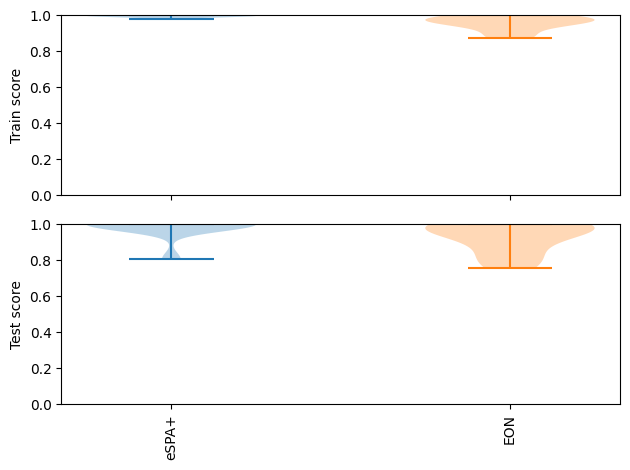

In [4]:
fig, axs = plt.subplots(2,1,sharex=True)

# For each classifier, perform cross-validation
for i, (name, clf) in enumerate(zip(names, classifiers)):

    # Initialize arrays to store scores
    test_scores = np.zeros(outer_cv.get_n_splits())
    train_scores = np.zeros(outer_cv.get_n_splits())

    # Perform crossvalidation using the split objects. It must be done manually (without cross_validate) to avoid refitting.
    for i_cv, (train_val_index, test_index) in enumerate(outer_cv.split(X, y)):

        # Separate test set from the training/validation set
        X_train_val, X_test = X[train_val_index], X[test_index]
        y_train_val, y_test = y[train_val_index], y[test_index]
        
        # Separate inner cross-validation indices
        train_index, val_index = next(inner_cv.split(X_train_val, y_train_val))
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        # Generate grid of hyperparameter combinations
        param_names, param_values = zip(*clf["param_grid"].items())
        hyperparam_combinations = [dict(zip(param_names, v)) for v in itertools.product(*param_values)]

        best_val_score = -np.inf
        best_fit_time = np.inf
        best_model = None
        for combination in hyperparam_combinations:
            est = clone(clf["estimator"])
            est.set_params(**combination)

            est.fit(X_train,y_train)

            # validation score
            val_score = roc_auc_score(y_val, est.predict_proba(X_val)[:,1])

            if val_score > best_val_score:
                best_val_score = val_score
                best_model = est        
        
        # Compute training and test scores
        train_scores[i_cv] = roc_auc_score(y_train_val[train_index], best_model.predict_proba(X_train_val[train_index])[:,1])
        
        # Calculare roc_auc score on the test set
        best_model.predict_proba(X_test)
        test_scores[i_cv] = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

        # Uncomment followign 2 lines to read something while fitting :)
        # print(f"Cross-validation {i_cv+1}/{outer_cv.get_n_splits()} for {name}")
        # print(f"{name} - Train score {train_scores[i_cv]:.2f}, Test score: {test_scores[i_cv]:.2f}")
        
    # Plot the results
    axs[0].violinplot(train_scores, [i])
    axs[1].violinplot(test_scores, [i])

axs[0].set_ylabel("Train score")
axs[0].set_ylim(0, 1)
axs[1].set_ylabel("Test score")
axs[1].set_ylim(0, 1)
axs[1].set_xticks(range(len(names)), labels=names, rotation="vertical")

plt.tight_layout()
plt.show()